# Importing libraries


In [54]:
from wordcloud import WordCloud
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
#!pip install neattext
import neattext.functions as nfx
import matplotlib.pyplot as plt
import plotly.express as plx
from sklearn.metrics import classification_report
import keras
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

In [55]:
data=pd.read_csv('Depression.csv')
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [56]:
data['class'].value_counts()

suicide        116037
non-suicide    116037
Name: class, dtype: int64

### Splitting data to train and test

In [57]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=10)

In [58]:
train_data['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

In [59]:
plx.bar(train_data,x=train_data['class'].value_counts().index.values,
        y=train_data['class'].value_counts(),color=['Depressed','Not Depressed'])

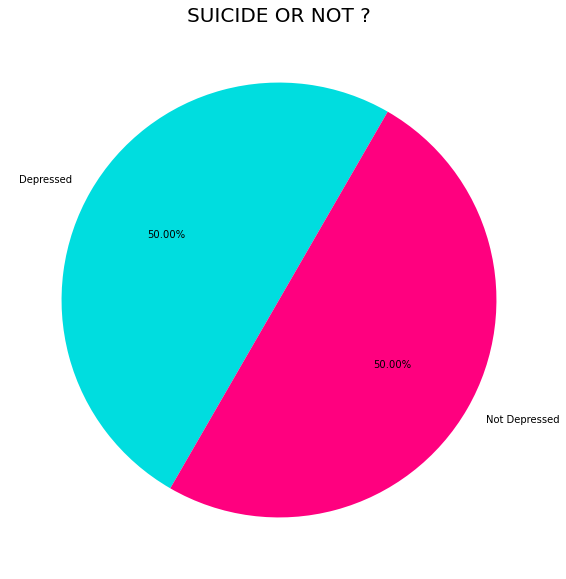

In [53]:
plt.figure(figsize=(12,10))
plt.pie(train_data['class'].value_counts(),startangle=60,colors=['#00dddf','#FF007F'],
        autopct='%0.2f%%',labels=['Depressed','Not Depressed'])
plt.title('SUICIDE OR NOT ?',fontdict={'size':20})
plt.show()

# Data cleaning and preprocessing


In [14]:

def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(text):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
#         sent=nfx.remove_shortwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

In [15]:
cleaned_train_text,train_text_length=clean_text(train_data.text)
cleaned_test_text,test_text_length=clean_text(test_data.text)

100%|██████████████████████████████████████████████████████████████████████████| 46415/46415 [00:06<00:00, 6899.42it/s]


### tokenizing the text

In [16]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

### word cloud

In [17]:
word_freq=pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)

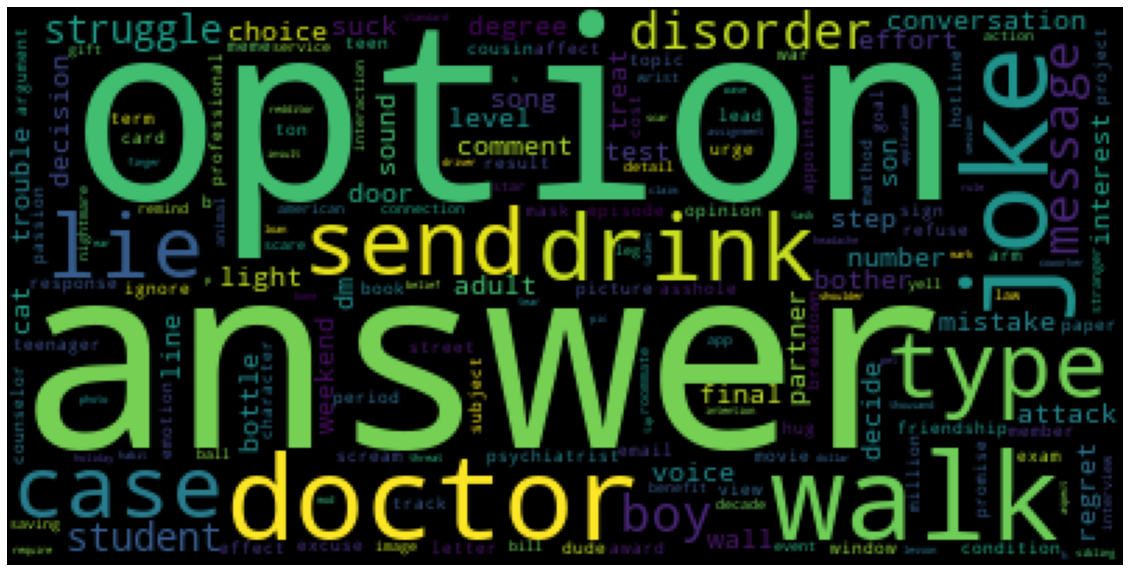

In [18]:
feature_names=word_freq['word'].values
wc=WordCloud(max_words=400)
wc.generate(' '.join(word for word in feature_names[500:3500] ))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)

### Encoding our text


In [19]:
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=50)


test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=50)

In [20]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

In [21]:
# glove_embedding={}
with open(r'C:\Users\mahab\Downloads\glove\glove.840B.300d.pkl', 'rb') as fp:
    glove_embedding = pickle.load(fp)

In [25]:
v=len(tokenizer.word_index)

embedding_matrix=np.zeros((v+1,300), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

# Model building

In [26]:
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

In [29]:
model=Sequential()
model.add(Input(shape=(50,)))
model.add(Embedding(v+1,300,weights=[embedding_matrix],trainable=False))
model.add(LSTM(20,return_sequences=True))
model.add(GlobalMaxPooling1D())
#     model.add(Dropout(0.3))
model.add(Dense(256,activation='relu'))
#     model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])

In [30]:
r=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=20,batch_size=256,callbacks=[early_stop,reducelr])

Epoch 1/20
726/726 [==============================] - 90s 99ms/step - loss: 0.3382 - accuracy: 0.8567 - val_loss: 0.2800 - val_accuracy: 0.8865 - lr: 0.1000
Epoch 2/20
726/726 [==============================] - 75s 104ms/step - loss: 0.2481 - accuracy: 0.9009 - val_loss: 0.2336 - val_accuracy: 0.9075 - lr: 0.1000
Epoch 3/20
726/726 [==============================] - 75s 104ms/step - loss: 0.2272 - accuracy: 0.9102 - val_loss: 0.2207 - val_accuracy: 0.9132 - lr: 0.1000
Epoch 4/20
726/726 [==============================] - 78s 107ms/step - loss: 0.2125 - accuracy: 0.9172 - val_loss: 0.2609 - val_accuracy: 0.8960 - lr: 0.1000
Epoch 5/20
726/726 [==============================] - 76s 104ms/step - loss: 0.1971 - accuracy: 0.9234 - val_loss: 0.2351 - val_accuracy: 0.9094 - lr: 0.1000
Epoch 6/20
726/726 [==============================] - 76s 104ms/step - loss: 0.1854 - accuracy: 0.9285 - val_loss: 0.2012 - val_accuracy: 0.9226 - lr: 0.1000
Epoch 7/20
726/726 [==============================] -

# Evaluating Our Model

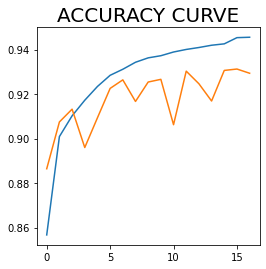

In [32]:
plt.figure(figsize=(4,4))
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.show()

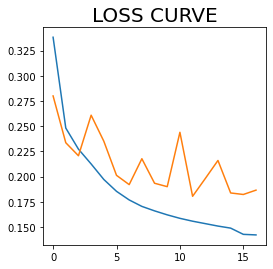

In [33]:
plt.figure(figsize=(4,4))
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.show()

### Saving the model

In [34]:
model.save("depression.h5")

In [35]:
print('TESTING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(test_output,(model.predict(test_text_pad) > 0.5).astype("int32"),
                            target_names=lbl_target.inverse_transform([0,1])))
 
print('TRAINING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(train_output,(model.predict(train_text_pad) > 0.5).astype("int32"),
                           target_names=lbl_target.inverse_transform([0,1])))

TESTING DATA CLASSIFICATION REPORT 
 

1451/1451 [==============================] - 41s 27ms/step
              precision    recall  f1-score   support

 non-suicide       0.91      0.95      0.93     23209
     suicide       0.95      0.91      0.93     23206

    accuracy                           0.93     46415
   macro avg       0.93      0.93      0.93     46415
weighted avg       0.93      0.93      0.93     46415

TRAINING DATA CLASSIFICATION REPORT 
 

5802/5802 [==============================] - 123s 21ms/step
              precision    recall  f1-score   support

 non-suicide       0.94      0.95      0.95     92828
     suicide       0.95      0.94      0.95     92831

    accuracy                           0.95    185659
   macro avg       0.95      0.95      0.95    185659
weighted avg       0.95      0.95      0.95    185659



### Model prediction

In [36]:
def detectDep(text):
    cleaned_text, length = clean_text(text)
    tokens = tokenizer.texts_to_sequences(cleaned_text)
    paded = pad_sequences(tokens,maxlen=50)
    if model.predict([paded]) >=0.55:
        print("contains suicidal thoughts")
    else:
        print("Doesn't contains suicidal thoughts")

In [50]:
detectDep(["I feel Loneliness in my life"])

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 804.59it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 73ms/step
contains suicidal thoughts
